# Metro21 Fire Prediction Reseach Project

## Motivation
In 2015 alone, there were over 500,000 structure fires in the United States, causing 2,600 civilian deaths and
$10.3 billion in property damage [1].

Municipal fire departments are required to inspect certain types of properties to ensure compliance with fire
safety standards and protocols [2].



## Datasets 

Fire Incidents (2009-2017) - Bureau of Fire
Business Licenses (2017) - PLI
PLI Violations (2016-2017) - PLI
Property Condition Assessment (2017) - WPRDC
311 Service Requests (2009-2017) - WPRDC

## Initial data Loading and Preprocessing  

The datasets are loaded and preprocessed thoroughly. The data is aggregated to an address level as the fires are at an address level.  

Client meetings are held to obtain domain expertise to determine what types actually are fires and what could be used as features to predict future fires.  



In [37]:
#importing relevant libraries
import pandas as pd 
import numpy as np
import sqlalchemy as sa
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
%matplotlib inline

# Reading plidata
plidata = pd.read_csv('datasets/pli.csv',encoding = 'utf-8',dtype={'STREET_NUM':'str','STREET_NAME':'str'})
#Reading city of Pittsburgh dataset 
pittdata = pd.read_csv('Datasets/pittdata.csv',dtype={'PROPERTYADDRESS':'str','PROPERTYHOUSENUM':'str','STATEDESC':'str'})
# #Reading 311 file
# calldata = pd.read_csv('Datasets/311.csv')

# #Cleaning function for address column in calldata
# def removingZeros(x):
#     x = x.replace('  ',' ')
#     if x[0] == 0 and x[1]==0: 
#         x= x.replace('0','',2)
#     elif x[0] == 0:
#         x= x.replace('0','',1)
#     return x

# #cleaning 311 data 
# calldata = calldata.dropna(subset = ['ADDRESS'])
# calldata['ADDRESS'] = calldata['ADDRESS'].map(lambda x : removingZeros(x))
# calldata['street_num'], calldata ['street_name'] = calldata['ADDRESS'].str.split(' ', 1).str
# calldata['street_name'] = calldata ['street_name'].str.upper()
# # calldata['street_name'] = calldata ['street_name'].str.replace('av','ave')

# #converting to datetime
# calldata.Date = pd.to_datetime(calldata.Date)
# calldata['call_year'] = calldata['Date'].map(lambda x: x.year)

#removing extra whitespaces
plidata['STREET_NAME'] = plidata['STREET_NAME'].str.strip()
plidata['STREET_NUM'] = plidata['STREET_NUM'].str.strip()

#removing residential data
pittdata = pittdata[pittdata.STATEDESC!='RESIDENTIAL']
pittdata = pittdata[pittdata.PROPERTYHOUSENUM!= '0']
pittdata = pittdata[pittdata.PROPERTYADDRESS!= '']

#dropping columns with less than 15% data 
pittdata = pittdata.dropna(thresh=4000, axis=1)
pittdata = pittdata.rename(columns={pittdata.columns[0]:'PARID'})
pittdata = pittdata.drop_duplicates()

#merging pli with city of pitt 
plipca = pd.merge(pittdata, plidata[['PARCEL','INSPECTION_DATE','INSPECTION_RESULT','VIOLATION']], how = 'left', left_on =['PARID'], right_on = ['PARCEL'] )
plipca = plipca.drop_duplicates()

#dropping nas
newpli = plipca.dropna(subset =['PARCEL','INSPECTION_DATE','INSPECTION_RESULT','VIOLATION'] )
newpli = newpli.reset_index()
newpli = newpli.drop(['index','PARID','index',u'PROPERTYOWNER', 
       u'PROPERTYCITY', u'PROPERTYSTATE', u'PROPERTYUNIT', u'PROPERTYZIP',
       u'MUNICODE', u'MUNIDESC', u'SCHOOLCODE', u'SCHOOLDESC', u'NEIGHCODE',
       u'TAXCODE', u'TAXDESC', u'OWNERCODE', u'OWNERDESC', u'STATECODE',
       u'STATEDESC', u'USECODE', u'USEDESC', u'LOTAREA', u'SALEDATE',
       u'SALEPRICE', u'SALECODE', u'SALEDESC', u'DEEDBOOK', u'DEEDPAGE',
       u'AGENT', u'TAXFULLADDRESS1', u'TAXFULLADDRESS2', u'TAXFULLADDRESS3',
       u'TAXFULLADDRESS4', u'CHANGENOTICEADDRESS1', u'CHANGENOTICEADDRESS2',
       u'CHANGENOTICEADDRESS3', u'CHANGENOTICEADDRESS4', u'COUNTYBUILDING',
       u'COUNTYLAND', u'COUNTYTOTAL', u'COUNTYEXEMPTBLDG', u'LOCALBUILDING',
       u'LOCALLAND', u'LOCALTOTAL', u'FAIRMARKETBUILDING', u'FAIRMARKETLAND',
       u'FAIRMARKETTOTAL', u'PARCEL'], axis=1)

newpli = newpli.drop_duplicates()

#converting to datetime
newpli.INSPECTION_DATE = pd.to_datetime(newpli.INSPECTION_DATE)
newpli['violation_year'] = newpli['INSPECTION_DATE'].map(lambda x: x.year)

plipca.SALEPRICE = plipca.SALEPRICE.replace('NaN',0)

#Groups by address and replaces LOTAREA','SALEPRICE','FAIRMARKETLAND','FAIRMARKETBUILDING' by mean
numerical = plipca.groupby( [ "PROPERTYHOUSENUM", "PROPERTYADDRESS"] , as_index=False)[['LOTAREA','SALEPRICE',
                                                                            'FAIRMARKETLAND',
                                                                            'FAIRMARKETBUILDING']].mean()

# Following blocks of code group by address and get the category with maximum count for each given categorical columns 
temp = pd.DataFrame({'count' : plipca.groupby( [ "PROPERTYHOUSENUM", "PROPERTYADDRESS"] ).STATEDESC.value_counts()}).reset_index()
idx = temp.groupby([ "PROPERTYHOUSENUM", "PROPERTYADDRESS"])['count'].transform(max) == temp['count']
result1 = temp[idx]
result1 = result1.drop_duplicates(subset=[ "PROPERTYHOUSENUM", "PROPERTYADDRESS"], keep = 'last')
del result1['count']

temp = pd.DataFrame({'count' : plipca.groupby( [ "PROPERTYHOUSENUM", "PROPERTYADDRESS"] ).STATEDESC.value_counts()}).reset_index()
temp.groupby([ "PROPERTYHOUSENUM", "PROPERTYADDRESS"])['count'].transform(max)
idx = temp.groupby([ "PROPERTYHOUSENUM", "PROPERTYADDRESS"])['count'].transform(max) == temp['count']
result1 = temp[idx]
result1 = result1.drop_duplicates(subset=[ "PROPERTYHOUSENUM", "PROPERTYADDRESS"], keep = 'last')
del result1['count']

temp = pd.DataFrame({'count' : plipca.groupby( [ "PROPERTYHOUSENUM", "PROPERTYADDRESS"] ).SCHOOLDESC.value_counts()}).reset_index()
idx = temp.groupby([ "PROPERTYHOUSENUM", "PROPERTYADDRESS"])['count'].transform(max) == temp['count']
result2 = temp[idx]
result2 = result2.drop_duplicates(subset=[ "PROPERTYHOUSENUM", "PROPERTYADDRESS"], keep = 'last')
del result2['count']

temp = pd.DataFrame({'count' : plipca.groupby( [ "PROPERTYHOUSENUM", "PROPERTYADDRESS"] ).OWNERDESC.value_counts()}).reset_index()
idx = temp.groupby([ "PROPERTYHOUSENUM", "PROPERTYADDRESS"])['count'].transform(max) == temp['count']
result3 = temp[idx]
result3 = result3.drop_duplicates(subset=[ "PROPERTYHOUSENUM", "PROPERTYADDRESS"], keep = 'last')
del result3['count']

temp = pd.DataFrame({'count' : plipca.groupby( [ "PROPERTYHOUSENUM", "PROPERTYADDRESS"] ).MUNIDESC.value_counts()}).reset_index()
idx = temp.groupby([ "PROPERTYHOUSENUM", "PROPERTYADDRESS"])['count'].transform(max) == temp['count']
result4 = temp[idx]
result4 = result4.drop_duplicates(subset=[ "PROPERTYHOUSENUM", "PROPERTYADDRESS"], keep = 'last')
del result4['count']

temp = pd.DataFrame({'count' : plipca.groupby( [ "PROPERTYHOUSENUM", "PROPERTYADDRESS"] ).INSPECTION_RESULT.value_counts()}).reset_index()
idx = temp.groupby([ "PROPERTYHOUSENUM", "PROPERTYADDRESS"])['count'].transform(max) == temp['count']
result5 = temp[idx]
result5 = result5.drop_duplicates(subset=[ "PROPERTYHOUSENUM", "PROPERTYADDRESS"], keep = 'last')
del result5['count']

temp = pd.DataFrame({'count' : plipca.groupby( [ "PROPERTYHOUSENUM", "PROPERTYADDRESS"] ).NEIGHCODE.value_counts()}).reset_index()
idx = temp.groupby([ "PROPERTYHOUSENUM", "PROPERTYADDRESS"])['count'].transform(max) == temp['count']
result6 = temp[idx]
result6 = result6.drop_duplicates(subset=[ "PROPERTYHOUSENUM", "PROPERTYADDRESS"], keep = 'last')
del result6['count']

temp = pd.DataFrame({'count' : plipca.groupby( [ "PROPERTYHOUSENUM", "PROPERTYADDRESS"] ).TAXDESC.value_counts()}).reset_index()
idx = temp.groupby([ "PROPERTYHOUSENUM", "PROPERTYADDRESS"])['count'].transform(max) == temp['count']
result7 = temp[idx]
result7 = result7.drop_duplicates(subset=[ "PROPERTYHOUSENUM", "PROPERTYADDRESS"], keep = 'last')
del result7['count']

temp = pd.DataFrame({'count' : plipca.groupby( [ "PROPERTYHOUSENUM", "PROPERTYADDRESS"] ).USEDESC.value_counts()}).reset_index()
idx = temp.groupby([ "PROPERTYHOUSENUM", "PROPERTYADDRESS"])['count'].transform(max) == temp['count']
result8 = temp[idx]
result8 = result8.drop_duplicates(subset=[ "PROPERTYHOUSENUM", "PROPERTYADDRESS"], keep = 'last')
del result8['count']

dfs = [result1,result2,result3,result4,result6,result7,result8,numerical]

pcafinal = reduce(lambda left,right: pd.merge(left,right,on= [ "PROPERTYHOUSENUM", "PROPERTYADDRESS"] ), dfs)

plipca1 = pd.merge(pcafinal, newpli, how = 'left', left_on =[ "PROPERTYHOUSENUM", "PROPERTYADDRESS"], right_on = [ "PROPERTYHOUSENUM", "PROPERTYADDRESS"] )

#loading fire incidents csvs
fire_pre14 = pd.read_csv('Datasets/Fire_Incidents_Pre14.csv',encoding = 'latin-1',dtype={'street':'str','number':'str'})

#cleaning columns of fire_pre14
fire_pre14['full.code'] = fire_pre14['full.code'].str.replace('  -',' -')
fire_pre14['st_type'] = fire_pre14['st_type'].str.strip()
fire_pre14['street'] = fire_pre14['street'].str.strip()
fire_pre14['number'] = fire_pre14['number'].str.strip()
fire_pre14['st_type'] = fire_pre14['st_type'].str.replace('AV','AVE')
fire_pre14['street'] = fire_pre14['street'].str.strip() +' ' +fire_pre14['st_type'].str.strip()

#reading the fire_historicalfile
fire_historical = pd.read_csv('Datasets/Fire_Incidents_Historical.csv',encoding = 'utf-8',dtype={'street':'str','number':'str'})

#deleting columns not required
del fire_historical['inci_id']
del fire_historical['alm_dttm']
del fire_historical['arv_dttm']
del fire_historical['pbf_narcan']
del fire_historical['meds_glucose']
del fire_historical['meds_epi']
del fire_historical['meds_nitro']
del fire_historical['pbf_albut']
del fire_historical['cpr']
del fire_historical['car_arr']
del fire_historical['aed']
del fire_historical['none']
del fire_historical['pbf_lift_ass']
del fire_historical['Med_Assist']
del fire_historical['XCOORD']
del fire_historical['YCOORD']
del fire_historical['LOCATION']
del fire_historical['REP_DIST']
del fire_historical['alarms']
del fire_historical['inci_type']
del fire_historical['Lift_Ref']
del fire_historical['Card_CPR']
del fire_historical['AGENCY']
del fire_historical['PRIMARY_UNIT']
del fire_historical['MAP_PAGE']
del fire_historical['CURR_DGROUP']
del fire_historical['CALL_NO']
del fire_pre14['PRIMARY_UNIT']
del fire_pre14['MAP_PAGE']
del fire_pre14['alm_dttm']
del fire_pre14['arv_dttm']
del fire_pre14['XCOORD']
del fire_pre14['YCOORD']
del fire_pre14['inci_id']
del fire_pre14['inci_type']
del fire_pre14['alarms']
del fire_pre14['st_prefix']
del fire_pre14['st_suffix']
del fire_pre14['st_type']
del fire_pre14['CALL_NO']

cols = [0,4]
fire_pre14.drop(fire_pre14.columns[cols],axis=1,inplace=True)

#joining both the fire incidents file together
fire_historical = fire_historical.append(fire_pre14, ignore_index=True)

#more cleaning and removing descriptions which are not fire related
fire_historical['descript'] = fire_historical['descript'].str.strip()
fire_historical = fire_historical[fire_historical.descript != 'System malfunction, Other']
fire_historical = fire_historical[fire_historical.descript != 'Detector activation, no fire - unintentional']
fire_historical = fire_historical[fire_historical.descript != 'Smoke detector activation due to malfunction']
fire_historical = fire_historical[fire_historical.descript != 'Dispatched & cancelled en route']
fire_historical = fire_historical[fire_historical.descript != 'Dispatched & cancelled on arrival']
fire_historical = fire_historical[fire_historical.descript != 'EMS call, excluding vehicle accident with injury']
fire_historical = fire_historical[fire_historical.descript != 'Medical assist, assist EMS crew']
fire_historical = fire_historical[fire_historical.descript != 'Emergency medical service, other']
fire_historical = fire_historical[fire_historical.descript != 'Good intent call, Other']
fire_historical = fire_historical[fire_historical.descript != 'Rescue, EMS incident, other']
fire_historical = fire_historical[fire_historical.descript != 'Medical Alarm Activation (No Medical Service Req)']
fire_historical = fire_historical[fire_historical.descript != 'Motor Vehicle Accident with no injuries']
fire_historical = fire_historical[fire_historical.descript != 'No Incident found on arrival at dispatch address']
fire_historical = fire_historical[fire_historical.descript != 'Unintentional transmission of alarm, Other']
fire_historical = fire_historical[fire_historical.descript != 'Motor vehicle accident with injuries']
fire_historical = fire_historical[fire_historical.descript != 'Vehicle accident, general cleanup']
fire_historical = fire_historical[fire_historical.descript != 'Power line down']
fire_historical = fire_historical[fire_historical.descript != 'Person in distress, Other']
fire_historical = fire_historical[fire_historical.descript != 'Cable/Telco Wires Down']
fire_historical = fire_historical[fire_historical.descript != 'Service Call, other']
fire_historical = fire_historical[fire_historical.descript != 'Vehicle Accident canceled en route']
fire_historical = fire_historical[fire_historical.descript != 'Lock-out']
fire_historical = fire_historical[fire_historical.descript != 'False alarm or false call, Other']
fire_historical = fire_historical[fire_historical.descript != 'Assist police or other governmental agency']
fire_historical = fire_historical[fire_historical.descript != 'Special type of incident, Other']
fire_historical = fire_historical[fire_historical.descript != 'Alarm system sounded due to malfunction']
fire_historical = fire_historical[fire_historical.descript != 'Motor vehicle/pedestrian accident (MV Ped)']
fire_historical = fire_historical[fire_historical.descript != 'Assist invalid ']
fire_historical = fire_historical[fire_historical.descript != 'Malicious, mischievous false call, Other']
fire_historical = fire_historical[fire_historical.descript != 'Accident, potential accident, Other']
fire_historical = fire_historical[fire_historical.descript != 'Assist invalid']
fire_historical = fire_historical[fire_historical.descript != 'EMS call, party transported by non-fire agency']
fire_historical = fire_historical[fire_historical.descript != 'Rescue or EMS standby']
fire_historical = fire_historical[fire_historical.descript != 'Public service assistance, Other']
fire_historical = fire_historical[fire_historical.descript != 'Police matter']
fire_historical = fire_historical[fire_historical.descript != 'Lock-in (if lock out , use 511 )']
fire_historical = fire_historical[fire_historical.descript != 'Sprinkler activation, no fire - unintentional']
fire_historical = fire_historical[fire_historical.descript != 'Wrong location']
fire_historical = fire_historical[fire_historical.descript != 'Local alarm system, malicious false alarm']
fire_historical = fire_historical[fire_historical.descript != 'Authorized controlled burning']
fire_historical = fire_historical[fire_historical.descript != 'Water problem, Other']
fire_historical = fire_historical[fire_historical.descript != 'Passenger vehicle fire']
fire_historical = fire_historical[fire_historical.descript != 'CO detector activation due to malfunction']
fire_historical = fire_historical[fire_historical.descript != 'Authorized controlled burning']
fire_historical = fire_historical[fire_historical.descript != 'Steam, vapor, fog or dust thought to be smoke']
fire_historical = fire_historical[fire_historical.descript != 'Overheated motor']
fire_historical = fire_historical[fire_historical.descript != 'Local alarm system, malicious false alarm']
fire_historical = fire_historical[fire_historical.descript != 'Central station, malicious false alarm']
fire_historical = fire_historical[fire_historical.descript != 'Public service']
fire_historical = fire_historical[fire_historical.descript != 'Heat detector activation due to malfunction']
fire_historical = fire_historical[fire_historical.descript != 'Citizen complaint']
fire_historical = fire_historical[fire_historical.descript != 'Municipal alarm system, malicious false alarm']
fire_historical = fire_historical[fire_historical.descript != 'Sprinkler activation due to malfunction']
fire_historical = fire_historical[fire_historical.descript != 'Severe weather or natural disaster, Other']
fire_historical = fire_historical[fire_historical.descript != 'Water evacuation']
fire_historical = fire_historical[fire_historical.descript != 'Breakdown of light ballast']
fire_historical = fire_historical[fire_historical.descript != 'Extrication of victim(s) from vehicle']
fire_historical = fire_historical[fire_historical.descript != 'Flood assessment']
fire_historical = fire_historical[fire_historical.descript != 'Telephone, malicious false alarm']
fire_historical = fire_historical[fire_historical.descript != 'Cover assignment, standby, moveup']
fire_historical = fire_historical[fire_historical.descript != 'Road freight or transport vehicle fire']
fire_historical = fire_historical[fire_historical['full.code'].str.strip()  != '540 - Animal problem, Other']
fire_historical = fire_historical[fire_historical['full.code'].str.strip()  != '5532 - Public Education (Station Visit)']
fire_historical = fire_historical[fire_historical['full.code'].str.strip()  != '353 - Removal of victim(s) from stalled elevator']

#correcting problems with the street column
fire_historical['street'] = fire_historical['street'].replace(to_replace=', PGH', value='', regex=True)
fire_historical['street'] = fire_historical['street'].replace(to_replace=', P', value='', regex=True)
fire_historical['street'] = fire_historical['street'].replace(to_replace=',', value='', regex=True)
fire_historical['street'] = fire_historical['street'].replace(to_replace='#.*', value='', regex=True)
fire_historical['street'] = fire_historical['street'].str.strip()
fire_historical['number'] = fire_historical['number'].str.strip()

#converting to date time and extracting year 
fireDate, fireTime = fire_historical['CALL_CREATED_DATE'].str.split(' ', 1).str
fire_historical['CALL_CREATED_DATE']= fireDate
fire_historical['CALL_CREATED_DATE'] = pd.to_datetime(fire_historical['CALL_CREATED_DATE'])
fire_historical['fire_year'] = fire_historical['CALL_CREATED_DATE'].map(lambda x: x.year)

#removing all codes with less than 20 occurences
for col,val in fire_historical['full.code'].value_counts().iteritems():
    if val <20 and col[0]!= '1':
        fire_historical = fire_historical[fire_historical['full.code'] != col]

fire_historical = fire_historical.drop_duplicates()

#joining plipca with fireincidents
pcafire = pd.merge(plipca1, fire_historical, how = 'left', left_on =['PROPERTYADDRESS','PROPERTYHOUSENUM'], 
                  right_on = ['street','number'])

# making the fire column with all type 100s as fires
pcafire['fire'] = pcafire['full.code'].astype(str).str[0]
pcafire.loc[pcafire.fire == '1', 'fire'] = 'fire'
pcafire.loc[pcafire.fire != 'fire', 'fire'] = 'No fire'
pcafire['full.code'][pcafire['fire'] == 'fire'] = None

#Fire occured after inspection
pcafire1 = pcafire[(pcafire.CALL_CREATED_DATE >= pcafire.INSPECTION_DATE )]
pcafire1 = pcafire[(pcafire.CALL_CREATED_DATE >= pcafire.INSPECTION_DATE )]
pcafire1 = pcafire1[pd.notnull(pcafire1.INSPECTION_DATE)]

#checking if violation is in the same year as the fire and keeping only those
pcafire2 = pcafire1[(pcafire1.violation_year == pcafire1.fire_year)]

#joining all rows with no pli violations
fire_nopli = pd.concat([fire_historical, pcafire2[['number','street','CALL_CREATED_DATE','full.code','response_time','fire_year']], pcafire2[['number','street','CALL_CREATED_DATE','full.code','response_time','fire_year']]]).drop_duplicates(keep=False)
pcafire_nopli = pd.merge(pcafinal, fire_nopli, how = 'left', left_on =['PROPERTYADDRESS','PROPERTYHOUSENUM'], 
                  right_on = ['street','number'])

pcafire_nopli['fire'] = pcafire_nopli['full.code'].astype(str).str[0]
pcafire_nopli.loc[pcafire_nopli.fire == '1', 'fire'] = 'fire'
pcafire_nopli.loc[pcafire_nopli.fire != 'fire', 'fire'] = 'No fire'
pcafire_nopli['full.code'][pcafire_nopli['fire'] == 'fire'] = None

#combined_df is the final file
combined_df  = pcafire_nopli.append(pcafire2, ignore_index=True)

combined_df.to_csv('Final_Combined_Df.csv')

/Users/bs/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/bs/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Excluded Fire Incident Types

In our model, we will be predicting all Code 100s that occurred in non-residential properties.

The other codes will be used as predictive “features” of the properties in which they occurred, except for...


Some that should clearly be excluded:
Dispatched & cancelled en route,
Dispatched & cancelled on arrival,
Wrong location,
Local alarm system, malicious false alarm,
Authorized controlled burning,
Water problem, Other,
Smoke or odor removal,
Passenger vehicle fire,
CO detector activation due to malfunction,
Steam, vapor, fog or dust thought to be smoke

[Excerpted from longer list]


## One Hot Encoding, Validating Data and preparing testing and training data

If a fire occurs in April 2017, it needs to be made sure the incidents such as distress calls regarding smoke alarm 
systems, Non code 100 fire events, sprinkler systems are used as features only if they are occuring before the fire 
event. 
In the following code the above is implemented. Apart from that features are generated using one hot encoding. 

In [36]:
print len(test_data[test_data.duplicated(keep=False)])
print len(test_data)
len(testdata2[testdata2.duplicated(subset = ['PROPERTYHOUSENUM','PROPERTYADDRESS'])])


0
20580


0

In [39]:
#importing the necessary libraries
from sklearn import datasets, linear_model, cross_validation, grid_search
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder


#Removing vacant commerical land
combined_df = combined_df[combined_df.USEDESC!= 'VACANT COMMERCIAL LAND']

#converting back to 1 and 0
combined_df['fire'] = combined_df['fire'].map({'fire': 1, 'No fire': 0})

#one hot encoding the features 
ohe9 = pd.get_dummies(combined_df['VIOLATION'])
ohe8 = pd.get_dummies(combined_df['full.code'])
ohe10 = pd.get_dummies(combined_df['INSPECTION_RESULT'])

#concatenating the features together 
combined_df1 = pd.concat([combined_df[['PROPERTYADDRESS','PROPERTYHOUSENUM','CALL_CREATED_DATE','fire','fire_year']],ohe8,ohe9,ohe10], axis=1)


#PREPARING THE TESTING DATA

testdata = combined_df1[combined_df1.CALL_CREATED_DATE > '12/01/2016']
# del testdata['CALL_CREATED_DATE']
# del testdata['fire_year']
testdata2 = testdata.groupby( [ "PROPERTYHOUSENUM", "PROPERTYADDRESS"] ).sum().reset_index() #,'CALL_CREATED_DATE','fire_year'
testdata2.loc[testdata2.fire != 0, 'fire'] = 1

nofire2017 = pd.concat([pcafinal[["PROPERTYHOUSENUM","PROPERTYADDRESS"]], testdata2[["PROPERTYHOUSENUM","PROPERTYADDRESS"]],testdata2[["PROPERTYHOUSENUM","PROPERTYADDRESS"]]]).drop_duplicates(keep=False)

testdata2 = testdata2.append(nofire2017, ignore_index=True)
testdata2 = testdata2.fillna(0)

test_data = pd.merge(testdata2,pcafinal, on = ["PROPERTYHOUSENUM", "PROPERTYADDRESS"], how = 'left')
#test_data.fire.value_counts()


#One hot encoding the features for the test set
ohe1 = pd.get_dummies(test_data['STATEDESC'])
ohe2 = pd.get_dummies(test_data['SCHOOLDESC'])
ohe3 = pd.get_dummies(test_data['OWNERDESC'])
ohe4 = pd.get_dummies(test_data['MUNIDESC'])
ohe5 = pd.get_dummies(test_data['NEIGHCODE'])
ohe6 = pd.get_dummies(test_data['TAXDESC'])
ohe7 = pd.get_dummies(test_data['USEDESC'])

addresses = test_data['PROPERTYHOUSENUM'] +' '+ test_data['PROPERTYADDRESS']
state_desc = test_data['STATEDESC']
school_desc= test_data['SCHOOLDESC']
owner_desc= test_data['OWNERDESC']
muni_desc= test_data['MUNIDESC']
neigh_desc= test_data['NEIGHCODE']
tax_desc= test_data['TAXDESC']
use_desc= test_data['USEDESC']

#Deleting features not required anymore or already one hot encoded for the model
del test_data['CALL_CREATED_DATE']
del test_data['STATEDESC']
del test_data['SCHOOLDESC']
del test_data['OWNERDESC']
del test_data['MUNIDESC']
del test_data['NEIGHCODE']
del test_data['TAXDESC']
del test_data['USEDESC']
del test_data['fire_year']
del test_data['PROPERTYADDRESS']
del test_data['PROPERTYHOUSENUM']


#Concatenating everything back together
encoded_testdata = pd.concat([test_data,ohe1,ohe2,ohe3,ohe4,ohe5,ohe6,ohe7], axis=1)

#PREPARING THE TRAINING DATA

#Everything till 1st Dec 2016 is training data
traindata1 = combined_df1[combined_df1.CALL_CREATED_DATE <= '12/01/2016']

#Combining multiple instances of an address together
traindata = traindata1.groupby( [ "PROPERTYHOUSENUM", "PROPERTYADDRESS",'CALL_CREATED_DATE','fire_year'] ).sum().reset_index()
#Relabeling them
traindata.loc[traindata.fire != 0, 'fire'] = 1

#concatenating non fire, non pca and fire instances together
nofire_train = pd.concat([pcafinal[["PROPERTYHOUSENUM","PROPERTYADDRESS"]], traindata[["PROPERTYHOUSENUM","PROPERTYADDRESS"]],traindata[["PROPERTYHOUSENUM","PROPERTYADDRESS"]]]).drop_duplicates(keep=False)
traindata = traindata.append(nofire2017, ignore_index=True)
traindata = traindata.fillna(0)
train_data = pd.merge(traindata,pcafinal, on = ["PROPERTYHOUSENUM", "PROPERTYADDRESS"], how = 'left')
#train_data.fire.value_counts()

#creating on hot encoded features for the categorical values
ohe1 = pd.get_dummies(train_data['STATEDESC'])
ohe2 = pd.get_dummies(train_data['SCHOOLDESC'])
ohe3 = pd.get_dummies(train_data['OWNERDESC'])
ohe4 = pd.get_dummies(train_data['MUNIDESC'])
ohe5 = pd.get_dummies(train_data['NEIGHCODE'])
ohe6 = pd.get_dummies(train_data['TAXDESC'])
ohe7 = pd.get_dummies(train_data['USEDESC'])

#deleting the categories 
del train_data['STATEDESC']
del train_data['CALL_CREATED_DATE']
del train_data['SCHOOLDESC']
del train_data['OWNERDESC']
del train_data['MUNIDESC']
del train_data['NEIGHCODE']
del train_data['TAXDESC']
del train_data['USEDESC']
del train_data['fire_year']
del train_data['PROPERTYADDRESS']
del train_data['PROPERTYHOUSENUM']

#concatenating all the created features together 
encoded_traindata = pd.concat([train_data,ohe1,ohe2,ohe3,ohe4,ohe5,ohe6,ohe7], axis=1)

#converting to array and reshaping the data to prep for model 
fireVarTrain = encoded_traindata['fire']
del encoded_traindata['fire']
X_train = np.array(encoded_traindata)
y_train = np.reshape(fireVarTrain.values,[fireVarTrain.shape[0],])

#converting to array and reshaping the data to prep for model 
fireVarTest = encoded_testdata['fire']
del encoded_testdata['fire']
X_test = np.array(encoded_testdata)
y_test = np.reshape(fireVarTest.values,[fireVarTest.shape[0],])




/Users/bs/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/bs/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)



## The XG Boost model
Grid Search was taking too long a time to run and I didn't want to invest in GPU acceleration due to budget restrictions.
Hence did hyperparameter tuning manually and arrived at the below parameters giving the most optimal result.

[[20501   156]
 [   20    24]]
Accuracy =  0.991497995266
kappa score =  0.211592526937
AUC Score =  0.768951313004
recall =  0.545454545455
precision =  0.133333333333


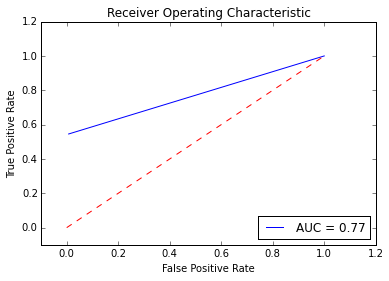

In [33]:
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

model = XGBClassifier( learning_rate =0.13,
n_estimators=1500,
max_depth=5,min_child_weight=1,
gamma=0,
subsample=0.8,
colsample_bytree=0.8,
objective= 'binary:logistic',
nthread=4,
seed=27)

model.fit(X_train, y_train)
pred = model.predict(X_test)
real = y_test
cm = confusion_matrix(real, pred)
print confusion_matrix(real, pred)

from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(real, pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

print 'Accuracy = ', float(cm[0][0] + cm[1][1])/len(real)
print 'kappa score = ', kappa
print 'AUC Score = ', metrics.auc(fpr, tpr)
print 'recall = ',tpr[1]
print 'precision = ',float(cm[1][1])/(cm[1][1]+cm[0][1])

#Plotting the ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr[1:], tpr[1:], 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Attempt at Random forest and other classification models with Cost Based learning

In [ ]:
from sklearn.ensemble import RandomForestClassifier


samples = np.array([0.1 if i == 0 else 1.2 for i in y_train])

model = RandomForestClassifier(n_estimators=500)
model.fit(X_train, y_train)
pred = model.predict(X_test)
real = y_test
cm = confusion_matrix(real, pred)
print confusion_matrix(real, pred)

from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(real, pred)

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)

print 'Accuracy = ', float(cm[0][0] + cm[1][1])/len(real)
print 'kappa score = ', kappa
print 'AUC Score = ', metrics.auc(fpr, tpr)
print 'recall = ',tpr[1]
print 'precision = ',float(cm[1][1])/(cm[1][1]+cm[0][1])


model = linear_model.LogisticRegression(C=1e5)
model.fit(X_train, y_train,sample_weight = samples)
pred = model.predict(X_test)
real = y_test
cm = confusion_matrix(real, pred)
print confusion_matrix(real, pred)

from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(real, pred)

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)

print 'Accuracy = ', float(cm[0][0] + cm[1][1])/len(real)
print 'kappa score = ', kappa
print 'AUC Score = ', metrics.auc(fpr, tpr)
print 'recall = ',tpr[1]
print 'precision = ',float(cm[1][1])/(cm[1][1]+cm[0][1])

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

model = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=2),
        n_estimators=600,
        learning_rate=1.5,
        algorithm="SAMME")
model.fit(X_train, y_train)
pred = model.predict(X_test)
real = y_test
cm = confusion_matrix(real, pred)
print confusion_matrix(real, pred)

from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(real, pred)

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)

print 'Accuracy = ', float(cm[0][0] + cm[1][1])/len(real)
print 'kappa score = ', kappa
print 'AUC Score = ', metrics.auc(fpr, tpr)
print 'recall = ',tpr[1]
print 'precision = ',float(cm[1][1])/(cm[1][1]+cm[0][1])

from sklearn import svm

model = svm.SVC(kernel='linear', C = 1.0)

model.fit(X_train, y_train)
pred = model.predict(X_test)
real = y_test
cm = confusion_matrix(real, pred)
print confusion_matrix(real, pred)

from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(real, pred)

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)

print 'Accuracy = ', float(cm[0][0] + cm[1][1])/len(real)
print 'kappa score = ', kappa
print 'AUC Score = ', metrics.auc(fpr, tpr)
print 'recall = ',tpr[1]
print 'precision = ',float(cm[1][1])/(cm[1][1]+cm[0][1])


from sklearn import svm

model = svm.SVC(kernel='linear', C = 1.0)

model.fit(X_train, y_train)
pred = model.predict(X_test)
real = y_test
cm = confusion_matrix(real, pred)
print confusion_matrix(real, pred)

from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(real, pred)

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)

print 'Accuracy = ', float(cm[0][0] + cm[1][1])/len(real)
print 'kappa score = ', kappa
print 'AUC Score = ', metrics.auc(fpr, tpr)
print 'recall = ',tpr[1]
print 'precision = ',float(cm[1][1])/(cm[1][1]+cm[0][1])

## Getting risk scores using probabilities 

The results file is ultimately used to visualize the properties on a map of Pittsburgh according to their risk.

In [5]:


predictions = model.predict_proba(X_test)
risk = []
for row in predictions: 
    risk.append(row[1])
cols = {"Address":addresses,"Fire":pred,"RiskScore":risk,"state_desc":state_desc,"school_desc":school_desc,
        "owner_desc":owner_desc,"muni_desc":muni_desc,"neigh_desc":neigh_desc,"tax_desc":tax_desc,"use_desc":use_desc}
Results = pd.DataFrame(cols)
Results.to_csv('Results.csv')


In [12]:
len(Results[Results.duplicated(keep=False)])# df[df.duplicated(['ID'], keep=False)]

69

## Feature Importance

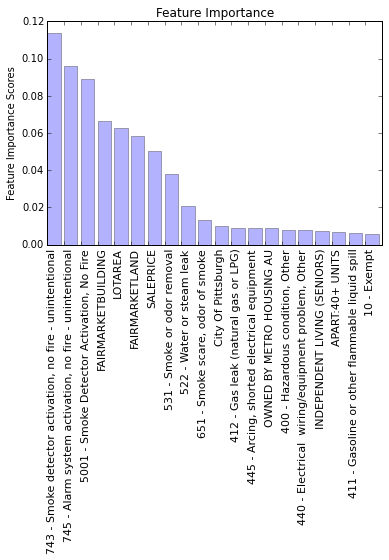

In [5]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier()
clf = clf.fit(X_train, y_train)
clf.feature_importances_

UsedDf = encoded_traindata
import pandas as pd
important_features = pd.Series(data=clf.feature_importances_,index=UsedDf.columns)
important_features.sort_values(ascending=False,inplace=True)

y_pos = np.arange(len(important_features.index[0:20]))

plt.bar(y_pos,important_features.values[0:20], alpha=0.3)
plt.xticks(y_pos, important_features.index[0:20], rotation = (90), fontsize = 11, ha='left')
plt.ylabel('Feature Importance Scores')
plt.title('Feature Importance')
 
plt.show()

# important_features1 = pd.Series(data=var,index=UsedDf.columns)
# important_features1.sort_values(ascending=False,inplace=True)
# print important_features1

## Implementing PCA for feature reduction 

Ultimately did not use it as it didn't show significant improvement over.


In [ ]:

#Scaling the values
X = scale(X_train)
pca = PCA(n_components=817)
pca.fit(X)

var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)


plt.semilogy(var, '--o');
plt.semilogy(var1, '--o');